# T_Matrix-Spectral_Analysis

# (Stage 3): Statistical Analysis of Translation Spectra 
In Stage 3 we extract the spectra of the translation matrices and find statistical properties of the spectra.

### Stage 3 steps:
1. Read in all translation matrices generated and exported as csv files in Stage 2
2. Calculate the spectral values and the log of the spectral values for:
    1. the raw translation matrix
    2. the covariance matrix of the translation matrix (optional)
3. Calculate statistical properties of the respective spectra (mean, max, min, median, std)
4. Export the resulting statistics as a json:
    * Example `../data/dim_300_loss_mse_l2=0_01_normality=0_000001/spec_analysis_stats.json`

Stage 3 is fully executed by running the following python script 
* `execute_spectral_analysis.py`
* The `$experiment` argument specifies the experiment in `../data` with the `T_matrices` csv files exported in stage 2.

In [2]:
# View the available translation hyperparameter experiments
experiments = !ls ../data
"These are the available experiments:"
i=0
for exp in experiments:
    print("(Experiment %r):  %s" % (i,exp))
    i+=1

(Experiment 0):  dim_100_loss_cos_l2_0_0001_normality_0_000001
(Experiment 1):  dim_100_loss_cos_l2_10_normality_0_000001
(Experiment 2):  dim_100_loss_cos_l2_1_normality_0_000001
(Experiment 3):  dim_300_loss_cos_l2_0_01_normality_0_000001
(Experiment 4):  dim_300_loss_cos_l2_1_normality_0_000001
(Experiment 5):  dim_300_loss_mse_l2_0_01_normality_0_000001
(Experiment 6):  dim_50_loss_cos_l2_0_01_normality_0_000001
(Experiment 7):  dim_50_loss_cos_l2_10_normality_0_000001


In [3]:
# specify which experiment in the list to run analysis on
# you can change the ind4x in the list experiments[1] to run analysis on a different experiment
experiment = experiments[2]
print(experiment)
# Run analysis with the execute_spectral_analysis.py script
!python execute_spectral_analysis.py $experiment

dim_100_loss_cos_l2_1_normality_0_000001
Using TensorFlow backend.
Translation Spectra Analyzed writing json to the following path:
../data/dim_100_loss_cos_l2_1_normality_0_000001/spec_analysis_stats.json


# (Stage 4): Plot Heatmaps of Spectra Statistics 

### Stage 4 steps:
1. Read in the json containing the statistical properties of the spectra calculated in stage 3, 
2. Plot as a heatmap grid the respective statistics associated with each translation.
    * The grid represents the translations from each language (row) to each other language (column).
    * Diagonals on the grid correspond to baselines for when a language is translated to itself.
    * Each heatmap is generated from 
        * a matrix type (translation matrix or or its covariance matrix), and
        * a different selected statistic.
    
Stage 4 can be executed locally with the following two functions from `ismtools`:
* `read_json` to read the json stats back in as the `T_matrix_dict`
* `plot_heatmaps` select which heatmaps you want to generate


Using TensorFlow backend.


mean of the translation matrix spectrum


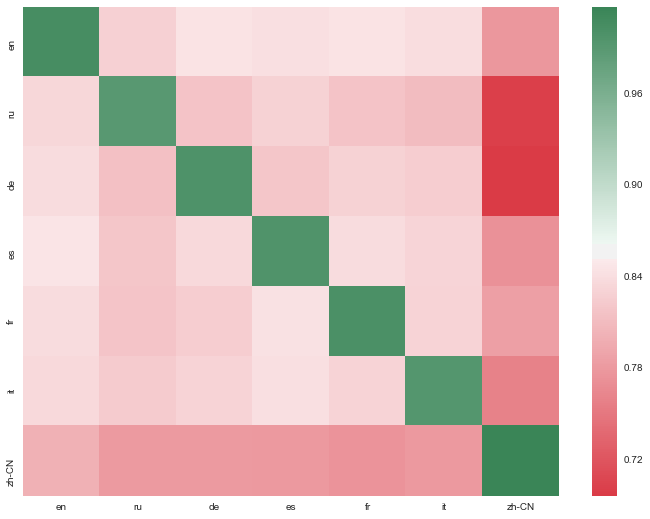

median of the translation matrix spectrum


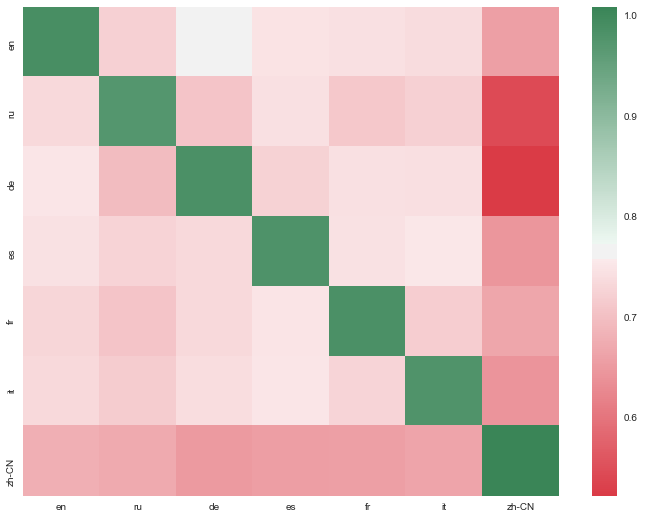

std of the translation matrix spectrum


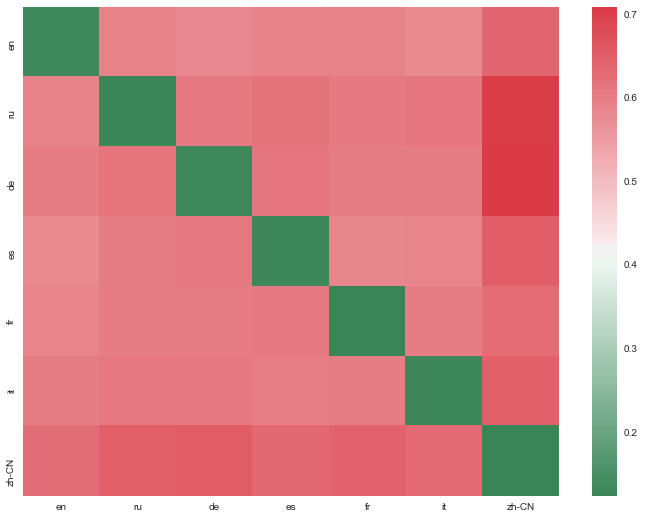

mean_log of the translation matrix spectrum


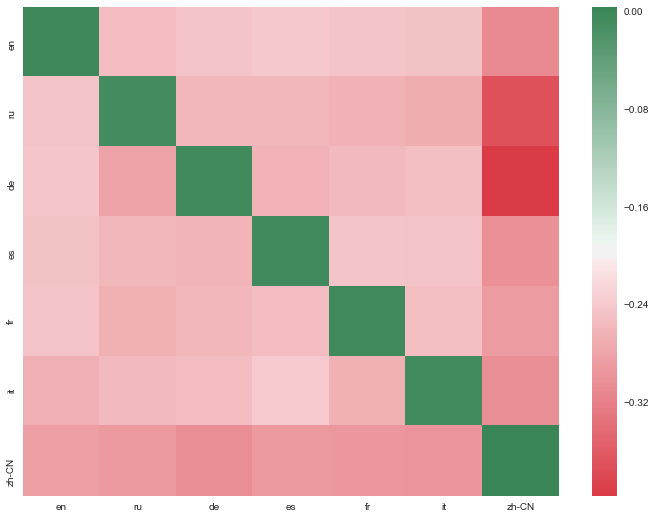

median_log of the translation matrix spectrum


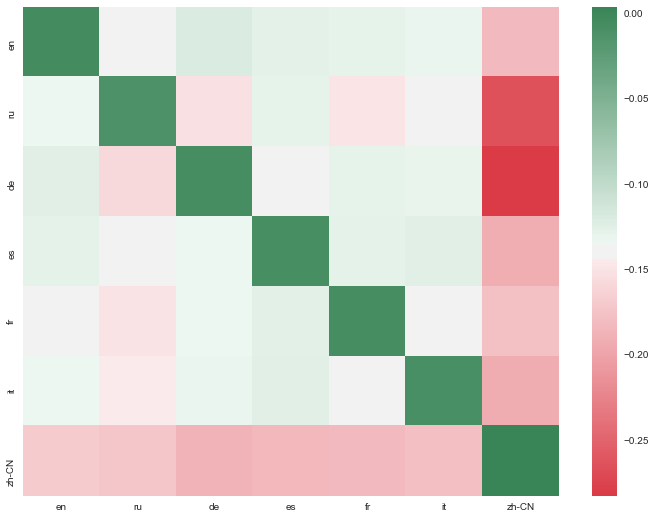

std_log of the translation matrix spectrum


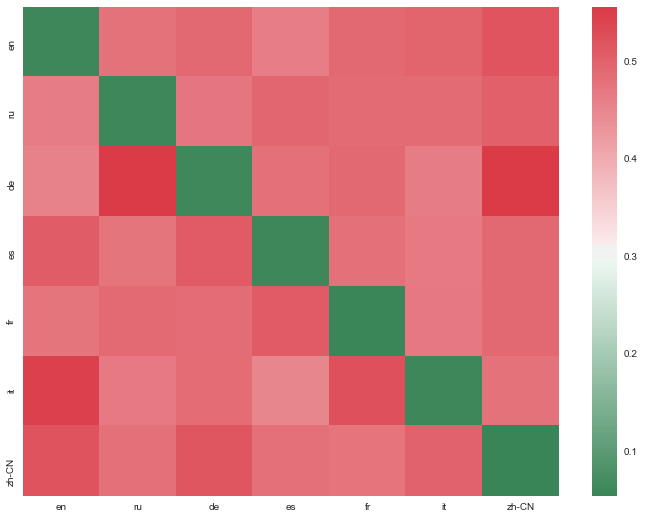

ortho_norm of the translation matrix spectrum


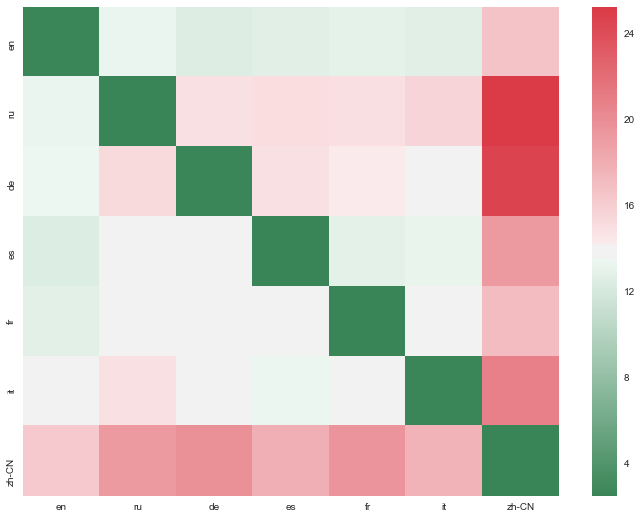

condition_num of the translation matrix spectrum


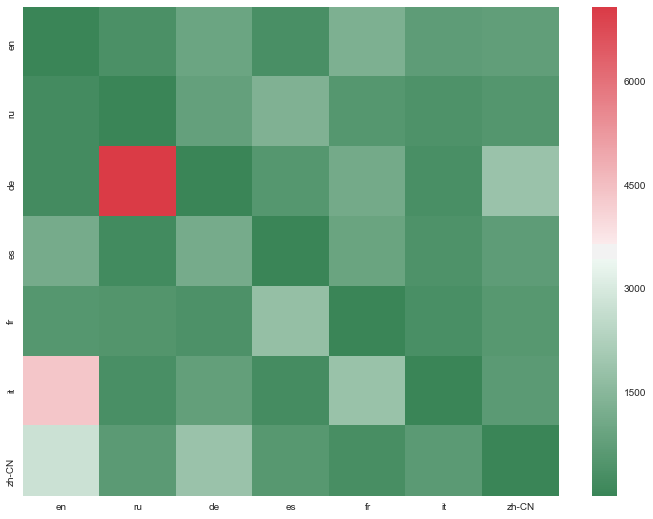

log_condition_num of the translation matrix spectrum


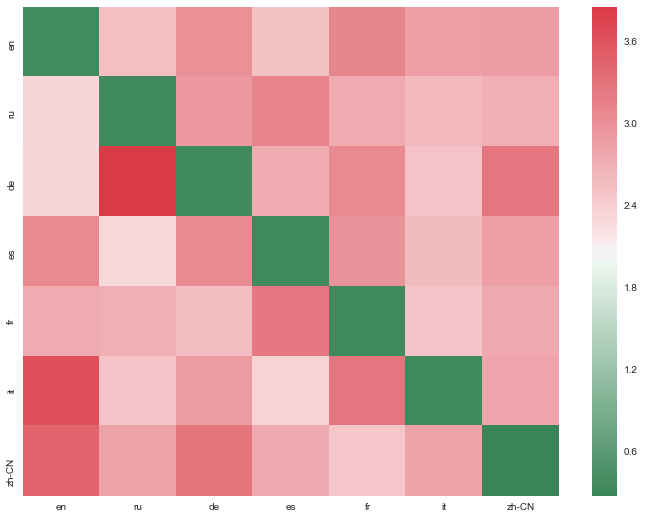

determinant of the translation matrix spectrum


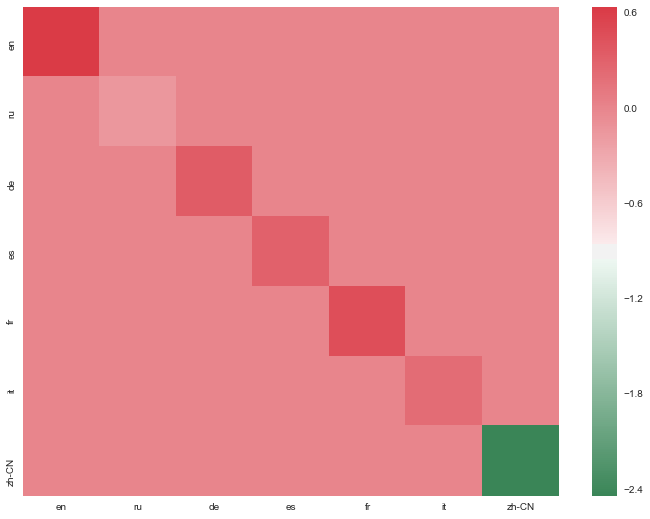

mean of the translation covariance matrix spectrum


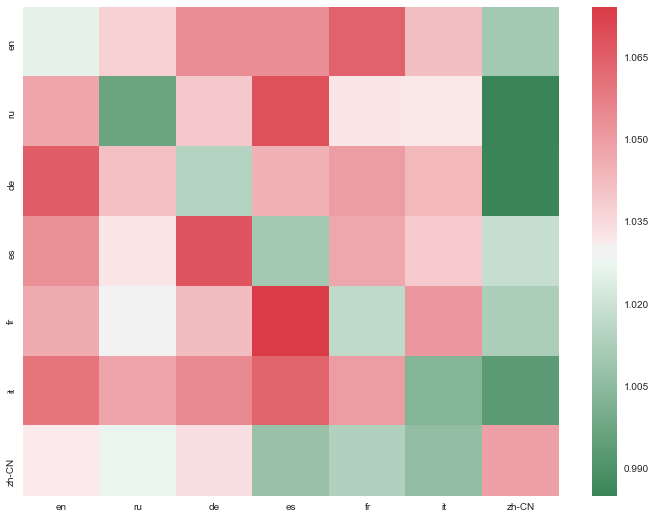

median of the translation covariance matrix spectrum


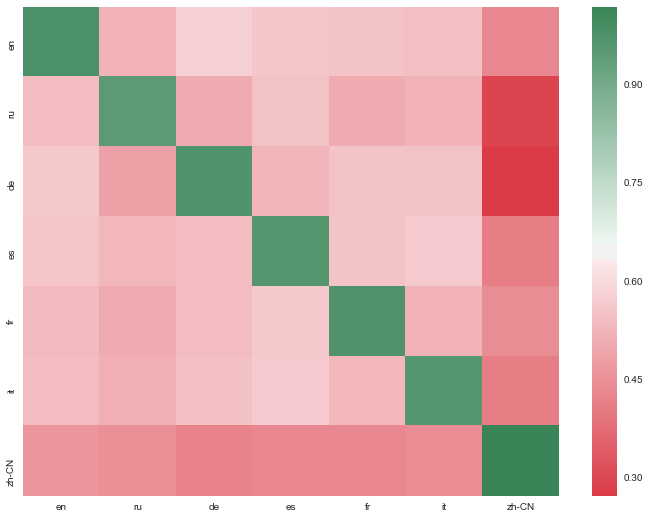

std of the translation covariance matrix spectrum


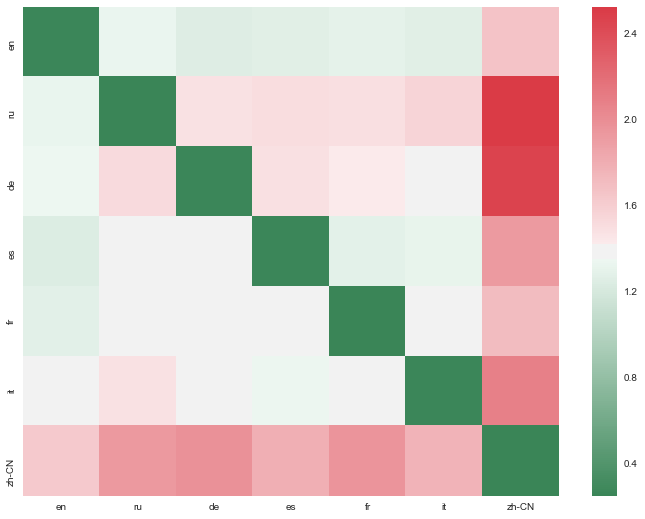

mean_log of the translation covariance matrix spectrum


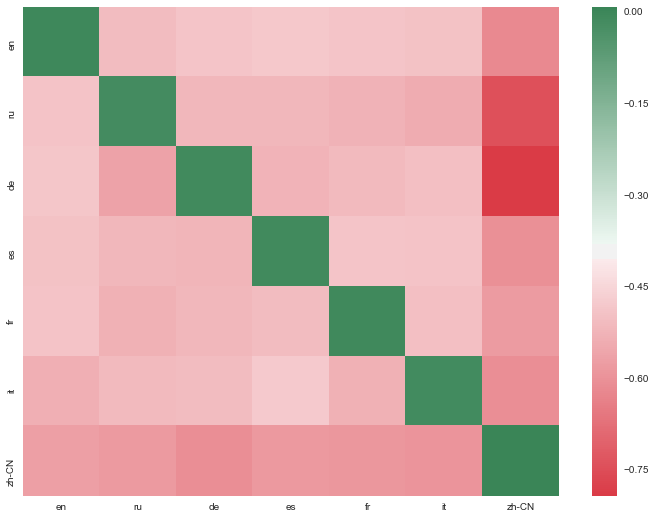

median_log of the translation covariance matrix spectrum


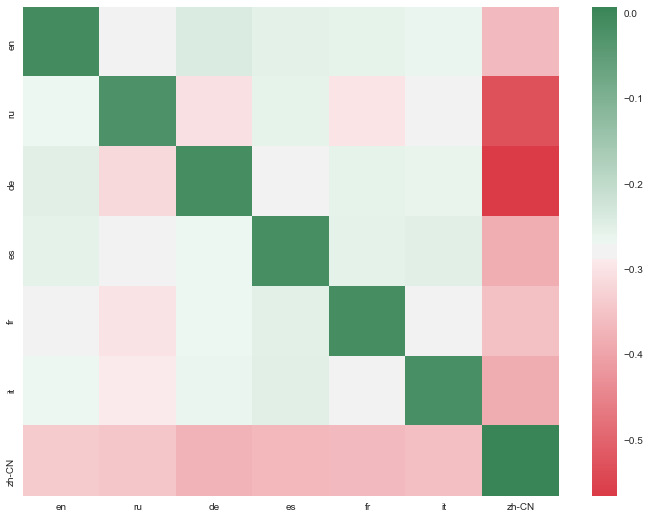

std_log of the translation covariance matrix spectrum


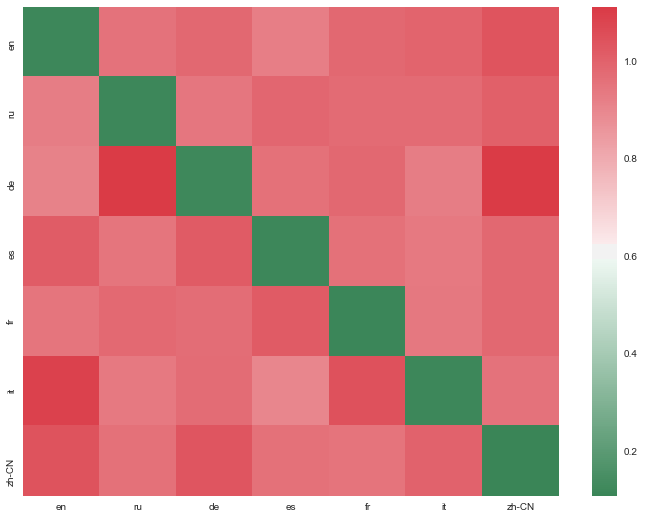

ortho_norm of the translation covariance matrix spectrum


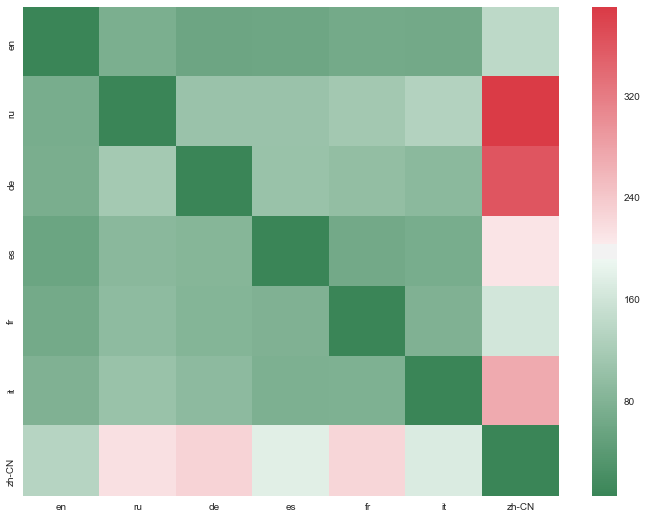

condition_num of the translation covariance matrix spectrum


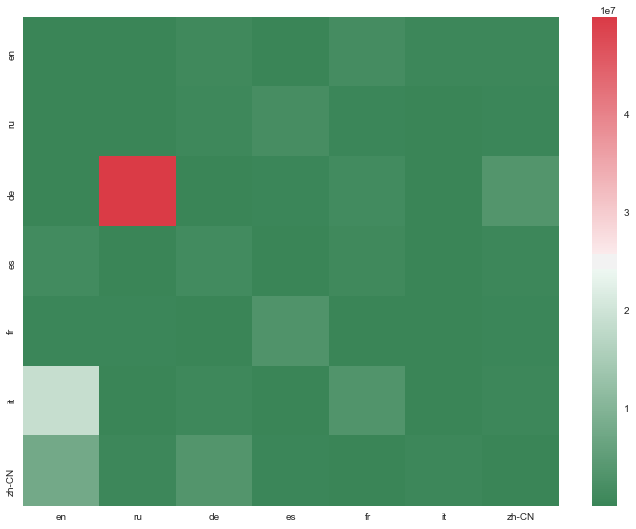

log_condition_num of the translation covariance matrix spectrum


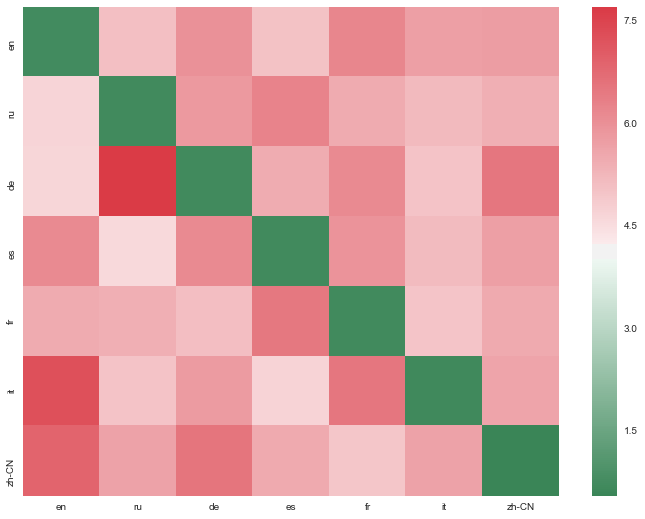

determinant of the translation covariance matrix spectrum


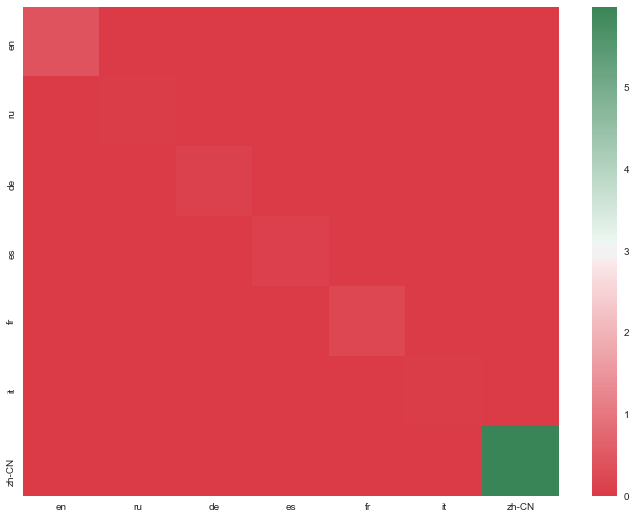

In [4]:
from ismtools import read_json, plot_heatmaps
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# Construct the JSON path based on the experiment chosen in stage 3

PATH = "../data/"+experiment
MATRIX_TYPES = ["T_matrix", "T_cov"]
STATS = [
         'mean', 
         'median', 
         'std', 
         'mean_log', 
         'median_log', 
         'std_log', 
         'ortho_norm',    #|T*T - I|_2
         'condition_num',
         'log_condition_num',
         'determinant'
        ]


heatmaps = plot_heatmaps(T_matrix_dict=read_json(PATH+"/spec_analysis_stats.json"),
                         plotted_stats=STATS,
                         display_opt="cols",
                         matrix_types=MATRIX_TYPES,
                         low_c=10,
                         high_c=140,
                         sep_num=8,
                         figuresize=[12,9],
                         write_heatmaps=PATH
                        )

In [ ]:
### RUN THROUGH ALL EXPERIMENTS ###
from ismtools import read_json, plot_heatmaps
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# View the available translation hyperparameter experiments
experiments = !ls ../data
"These are the available experiments:"
i=0
for exp in experiments:
    print("(Experiment %r):  %s" % (i,exp))
    i+=1

for experiment in experiments:
    !python execute_spectral_analysis.py $experiment
    
    # Construct the JSON path based on the experiment chosen in stage 3

    PATH = "../data/"+experiment
    MATRIX_TYPES = ["T_matrix", "T_cov"]
    STATS = [
             'mean', 
             'median', 
             'std', 
             'mean_log', 
             'median_log', 
             'std_log', 
             'ortho_norm',    #|T*T - I|_2
             'condition_num',
             'log_condition_num',
             'determinant'
            ]


    heatmaps = plot_heatmaps(T_matrix_dict=read_json(PATH+"/spec_analysis_stats.json"),
                             plotted_stats=STATS,
                             display_opt="cols",
                             matrix_types=MATRIX_TYPES,
                             low_c=10,
                             high_c=140,
                             sep_num=8,
                             figuresize=[12,9],
                             write_heatmaps=PATH
                            )   